# <font color = "brown"> Vector Auto Regression (Log Difference Transformation) </font>

In [46]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
import warnings
import math
warnings.filterwarnings("ignore") # Ignore warnings

In [47]:
# Read preprocessed train and test data
training_data = pd.read_csv("../../preprocessed_data/mandatory_train.csv")
test_data = pd.read_csv("../../preprocessed_data/mandatory_test.csv")
LAG = 195

## <font color = "brown"> Define functions </font>

In [48]:
# Define metrics
# Cited from https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd, https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def DTW(s, t): # Function where s is 
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [49]:
# Log transformation
# This function takes df name, min_values & names as arrays and n number of predictors and transforms each columns to their log(values)

def LogTransform(df_name, min_values, name, n):
    for i in range(n):
        df_name[f'log_{name[i]}'] = np.log(df_name[name[i]] + abs(min_values[i]) + 1)
        df_name[f'log_shift_{name[i]}'] = np.log(df_name[name[i]].shift() + abs(min_values[i] + 1))
        df_name[f'shift_{name[i]}'] = df_name[name[i]].shift()
        df_name[f'log_difference{name[i]}'] = df_name[f'log_{name[i]}'] - df_name[f'log_shift_{name[i]}']
        df_name.drop([f'log_{name[i]}', f'log_shift_{name[i]}'], axis = 1, inplace = True)
        #print(df_name)
    return df_name.drop(name, axis = 1).dropna()

In [50]:
# This function finds the min values of every train and test columns

def FindMinVal(trains, tests, name, n):
    min_values = []
    for i in range(n):
        min_val = min(trains[name[i]].min(), tests[name[i]].min())
        min_values.append(min_val)
    return min_values

In [51]:
# Preprocess data to test different predictors

def Preprocess(name, n):
    trains = training_data[name]
    tests = test_data[name]
    trains.set_index(keys = name[0], inplace = True)
    tests.set_index(keys = name[0], inplace = True)

    # Log transform these data
    names = name[1:]
    min_values = FindMinVal(trains, tests, names, n)
    trains = LogTransform(trains.copy(), min_values, names, n) # For price & demand
    tests = LogTransform(tests.copy(), min_values, names, n)

    return trains, tests, min_values

In [52]:
# Trains the model, obtain beta hat

def train_model(trains):
    model = VAR(trains)
    model_fitted = model.fit(LAG)
    # Determines beta hat for Regions VIC Trading Price
    coef = model_fitted.params
    coef2 = coef['Regions VIC Trading Price ($/MWh)']
    return coef2

In [53]:
# Predicts data

def predict_model(train, coef2):
    history = train[len(train)-LAG:]
    history = [history[i] for i in range(len(history))]
    predictions = list()

    # Calculates y_hat by multiplying beta hat with the previous (lags) of prices and demands
    for t in range(len(tests)):
        length = len(history)
        lag = np.array([history[i] for i in range(length-LAG,length)][::-1]).flatten()  # the price & demand predictors
        newyhat = np.dot(lag, coef2[1:]) + coef2[0] 
        obs = test[t]
        predictions.append(newyhat)
        history.append(obs)
    
    # Transform back to price
    tess = [i[0] for i in test]
    tess = (np.exp(tess) * (shift_price_t + abs(min_price) + 1)) - abs(min_price) - 1
    predictions = (np.exp(predictions) * (shift_price_t  + abs(min_price) + 1)) - abs(min_price) - 1
    
    rmse = np.sqrt(mean_squared_error(tess, predictions))
    print('RMSE: %.3f' % rmse) # RMSE
    print('MAE: {:.3f}'.format(mean_absolute_error(tess, predictions))) # MAE
    print('MAPE: {:.3f}'.format(MAPE(tess, predictions))) #MAPE
    print(DTW(tess, predictions)) #DTW
    return predictions

In [54]:
def PlotPredictions(tests, preds):
    # Plot actual vs predicted price
    forecast = pd.DataFrame(preds, index=tests.index)
    dataframe = pd.concat([ tests,forecast['shift_Regions VIC Trading Price ($/MWh)']], axis=1)
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe.columns = ['Actual Price', 'Predicted Price']
    dataframe.plot(figsize = (16, 8))

### <font color = "brown"> For VIC Trading Price & VIC Operational Demand with Log Transformation </font>

In [55]:
# Define train and test data
name = ["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)"]
n = 2
trains, tests, min_values = Preprocess(name, n)

min_price = min_values[0]

In [56]:
tests

,shift_Regions VIC Trading Price ($/MWh),log_differenceRegions VIC Trading Price ($/MWh),shift_Regions VIC Operational Demand (MW),log_differenceRegions VIC Operational Demand (MW)
Time (UTC+10),,,,
2021-07-01 00:30:00,51.71,0.054597,5410.0,-0.027840
2021-07-01 01:00:00,90.51,-0.019247,5192.0,-0.023056
2021-07-01 01:30:00,73.91,-0.052215,5016.0,-0.024007
2021-07-01 02:00:00,33.79,0.016475,4837.0,-0.024180
2021-07-01 02:30:00,43.57,0.006005,4661.0,-0.019377
...,...,...,...,...
2021-08-11 21:30:00,70.00,-0.008732,6122.0,-0.024690
2021-08-11 22:00:00,61.52,-0.022674,5911.0,-0.025922
2021-08-11 22:30:00,43.00,0.018331,5695.0,-0.030240


In [57]:
# Saves shifted price at t-1
shift_price = trains['shift_Regions VIC Trading Price ($/MWh)']
trains = trains.drop('shift_Regions VIC Trading Price ($/MWh)', axis = 1)
shift_demand = trains['shift_Regions VIC Operational Demand (MW)']
trains = trains.drop('shift_Regions VIC Operational Demand (MW)', axis = 1)

In [58]:
shift_price_t = tests['shift_Regions VIC Trading Price ($/MWh)']
tests = tests.drop('shift_Regions VIC Trading Price ($/MWh)', axis = 1)
shift_demand_t = tests['shift_Regions VIC Operational Demand (MW)']
tests = tests.drop('shift_Regions VIC Operational Demand (MW)', axis = 1)

In [59]:
trains.columns = name[1:]
tests.columns = name[1:]

In [60]:
train = trains.values
test = tests.values

In [61]:
coef = train_model(trains)

In [62]:
preds = predict_model(train, coef)

RMSE: 66.282
MAE: 22.133
MAPE: 152.683
[[0.00000000e+00            inf            inf ...            inf
             inf            inf]
 [           inf 3.49549710e+01 6.65435757e+01 ... 1.33418433e+05
  1.33471329e+05 1.33511956e+05]
 [           inf 5.31595861e+01 4.97932199e+01 ... 1.21072497e+05
  1.21108643e+05 1.21132519e+05]
 ...
 [           inf 1.27044677e+05 1.26529675e+05 ... 1.88281784e+04
  1.88334071e+04 1.88263665e+04]
 [           inf 1.27051102e+05 1.26539467e+05 ... 1.88210860e+04
  1.88326013e+04 1.88271206e+04]
 [           inf 1.27055388e+05 1.26547119e+05 ... 1.88232258e+04
  1.88347410e+04 1.88285063e+04]]


In [83]:
preds

Time (UTC+10)
2021-07-01 00:30:00    57.517724
2021-07-01 01:00:00    57.754885
2021-07-01 01:30:00    68.873493
2021-07-01 02:00:00    32.102456
2021-07-01 02:30:00    41.844385
                         ...    
2021-08-11 21:30:00    60.733932
2021-08-11 22:00:00    49.322224
2021-08-11 22:30:00    39.044617
2021-08-11 23:00:00    39.081144
2021-08-11 23:30:00    52.857097
Name: shift_Regions VIC Trading Price ($/MWh), Length: 2015, dtype: float64

In [63]:
tests = np.exp(tests['Regions VIC Trading Price ($/MWh)']) * (shift_price_t + abs(min_price) + 1) - abs(min_price) - 1

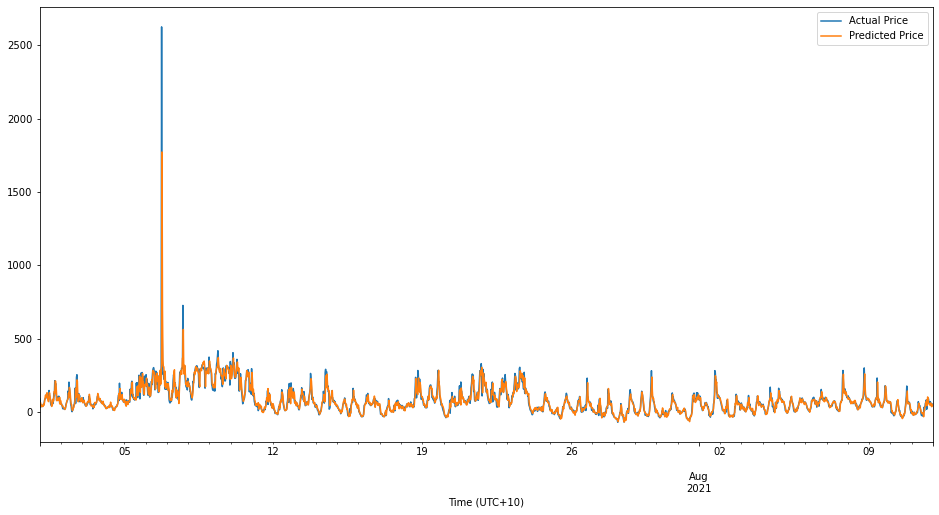

In [64]:
# Plot actual vs predicted price
PlotPredictions(tests, preds)

### <font color = "brown"> For VIC Trading Price & NSW Trading Demand with Log Transformation </font>

In [65]:
# Define train and test data
name = ["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions NSW Trading Price ($/MWh)"]
n = 2
trains, tests, min_values = Preprocess(name, n)

min_price = min_values[0]

In [66]:
# Saves shifted price at t-1
shift_price = trains['shift_Regions VIC Trading Price ($/MWh)']
trains = trains.drop('shift_Regions VIC Trading Price ($/MWh)', axis = 1)
shift_demand = trains['shift_Regions NSW Trading Price ($/MWh)']
trains = trains.drop('shift_Regions NSW Trading Price ($/MWh)', axis = 1)

In [67]:
shift_price_t = tests['shift_Regions VIC Trading Price ($/MWh)']
tests = tests.drop('shift_Regions VIC Trading Price ($/MWh)', axis = 1)
shift_demand_t = tests['shift_Regions NSW Trading Price ($/MWh)']
tests = tests.drop('shift_Regions NSW Trading Price ($/MWh)', axis = 1)

In [68]:
trains.columns = name[1:]
tests.columns = name[1:]

In [69]:
train = trains.values
test = tests.values

In [70]:
coef2 = train_model(trains)

In [71]:
preds = predict_model(train, coef2)

RMSE: 67.954
MAE: 23.998
MAPE: 193.337
[[0.00000000e+00            inf            inf ...            inf
             inf            inf]
 [           inf 4.55344342e+01 6.22028049e+01 ... 1.33543725e+05
  1.33588059e+05 1.33628798e+05]
 [           inf 7.43185126e+01 4.56164194e+01 ... 1.21450655e+05
  1.21478238e+05 1.21502228e+05]
 ...
 [           inf 1.30433661e+05 1.28304612e+05 ... 2.19650021e+04
  2.19558828e+04 2.19556228e+04]
 [           inf 1.30437815e+05 1.28329324e+05 ... 2.19600670e+04
  2.19588357e+04 2.19562637e+04]
 [           inf 1.30444108e+05 1.28351896e+05 ... 2.19669714e+04
  2.19639282e+04 2.19577625e+04]]


In [72]:
tests = np.exp(tests['Regions VIC Trading Price ($/MWh)']) * (shift_price_t + abs(min_price) + 1) - abs(min_price) - 1

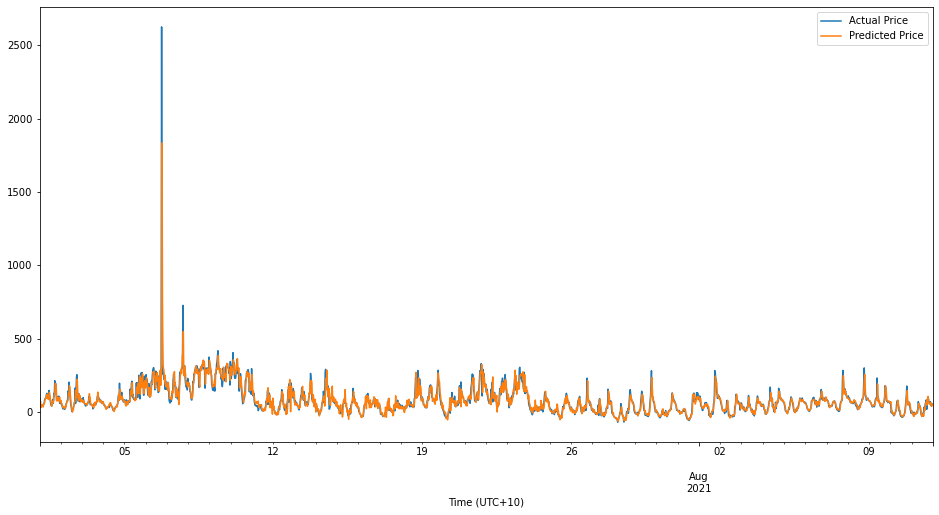

In [73]:
PlotPredictions(tests, preds)

###  <font color = "brown"> For Regions VIC Trading Price, Regions VIC Operational Demand &  Regions NSW Trading Price </font>

In [74]:
# Define train and test data
name = ["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)", "Regions NSW Trading Price ($/MWh)"]
n = 3
trains, tests, min_values = Preprocess(name, n)

min_price = min_values[0]

In [75]:
# Saves shifted price at t-1
shift_price = trains['shift_Regions VIC Trading Price ($/MWh)']
trains = trains.drop('shift_Regions VIC Trading Price ($/MWh)', axis = 1)
shift_demand = trains['shift_Regions VIC Operational Demand (MW)']
trains = trains.drop('shift_Regions VIC Operational Demand (MW)', axis = 1)
shift_nsw_price = trains['shift_Regions NSW Trading Price ($/MWh)']
trains = trains.drop('shift_Regions NSW Trading Price ($/MWh)', axis = 1)

In [76]:
shift_price_t = tests['shift_Regions VIC Trading Price ($/MWh)']
tests = tests.drop('shift_Regions VIC Trading Price ($/MWh)', axis = 1)
shift_demand_t = tests['shift_Regions VIC Operational Demand (MW)']
tests = tests.drop('shift_Regions VIC Operational Demand (MW)', axis = 1)
shift_nsw_price_t = tests['shift_Regions NSW Trading Price ($/MWh)']
tests = tests.drop('shift_Regions NSW Trading Price ($/MWh)', axis = 1)

In [77]:
trains.columns = name[1:]
tests.columns = name[1:]

In [78]:
train = trains.values
test = tests.values

In [79]:
coef3 = train_model(trains)

In [80]:
preds = predict_model(train, coef3)

RMSE: 66.710
MAE: 23.794
MAPE: 166.934
[[0.00000000e+00            inf            inf ...            inf
             inf            inf]
 [           inf 3.51045054e+01 6.99718501e+01 ... 1.33800189e+05
  1.33853730e+05 1.33893496e+05]
 [           inf 5.34586549e+01 5.32214942e+01 ... 1.21973304e+05
  1.22010095e+05 1.22033109e+05]
 ...
 [           inf 1.27073783e+05 1.27026663e+05 ... 2.35472266e+04
  2.35566350e+04 2.35487330e+04]
 [           inf 1.27080059e+05 1.27033176e+05 ... 2.35370559e+04
  2.35492165e+04 2.35503485e+04]
 [           inf 1.27084195e+05 1.27037550e+05 ... 2.35391957e+04
  2.35513562e+04 2.35497407e+04]]


In [81]:
tests = np.exp(tests['Regions VIC Trading Price ($/MWh)']) * (shift_price_t + abs(min_price) + 1) - abs(min_price) - 1

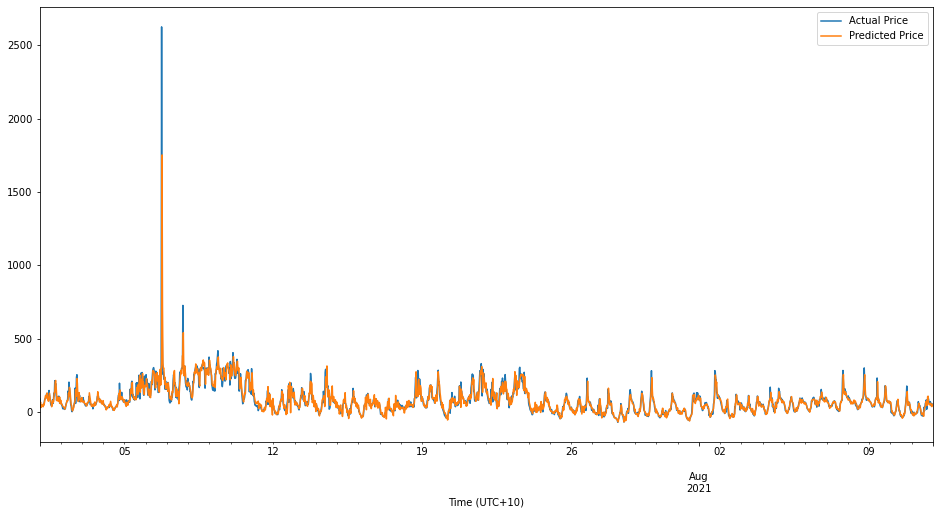

In [82]:
PlotPredictions(tests, preds)

------------

### *For checking purposes only*

### #1. *Calculate Manual VAR() to check*

In [76]:
data = pd.read_excel("../../raw_data/market_data.xlsx")

In [77]:
vic_only = data[['Time (UTC+10)', 'Regions VIC Trading Price ($/MWh)', 'Regions VIC Trading Total Intermittent Generation (MW)', 'Regions VIC Operational Demand (MW)']]

In [78]:
vic = data[['Time (UTC+10)', 'Regions VIC Trading Price ($/MWh)', 'Regions VIC Operational Demand (MW)']]
vic.columns = ['Time', 'Price', 'Demand']

In [79]:
# Add lags
df = pd.DataFrame()
df['Price'] = vic['Price'].copy()
for cols in ['Price', 'Demand']:
    for i in range(1, 197): # 147 lags
        df[f'{cols}_-{i}'] = vic[cols].shift(i)

In [80]:
df_train = df.loc[0:61295]
df_train = df_train.dropna().reset_index(drop = True)
df_train

,Price,Price_-1,Price_-2,Price_-3,Price_-4,Price_-5,Price_-6,Price_-7,Price_-8,Price_-9,...,Demand_-187,Demand_-188,Demand_-189,Demand_-190,Demand_-191,Demand_-192,Demand_-193,Demand_-194,Demand_-195,Demand_-196
0,57.48,61.50,75.22,78.06,114.52,81.61,63.21,64.97,67.90,71.57,...,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0,4398.0,4599.0
1,55.34,57.48,61.50,75.22,78.06,114.52,81.61,63.21,64.97,67.90,...,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0,4398.0
2,56.63,55.34,57.48,61.50,75.22,78.06,114.52,81.61,63.21,64.97,...,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0
3,56.06,56.63,55.34,57.48,61.50,75.22,78.06,114.52,81.61,63.21,...,3731.0,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0
4,53.90,56.06,56.63,55.34,57.48,61.50,75.22,78.06,114.52,81.61,...,3786.0,3731.0,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61095,65.79,67.14,74.16,76.02,77.33,112.48,126.68,158.89,139.51,72.98,...,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0,6149.0,6313.0
61096,92.52,65.79,67.14,74.16,76.02,77.33,112.48,126.68,158.89,139.51,...,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0,6149.0
61097,67.46,92.52,65.79,67.14,74.16,76.02,77.33,112.48,126.68,158.89,...,4945.0,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0
61098,60.16,67.46,92.52,65.79,67.14,74.16,76.02,77.33,112.48,126.68,...,4788.0,4945.0,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0


In [81]:
df_test = df.loc[61296:63311]

In [82]:
y = df_train['Price'].to_numpy()
del df_train['Price']

In [83]:
df_train.insert(0, 'intercept', 1)

In [86]:
# Converts df to numpy arrays
X = df_train.to_numpy()

In [87]:
# Calculates beta hat = (X^T.X)^-1 * X^T.Y
b = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))

In [88]:
# Predict train data
pred = []
for i in df_train.index:
    yhat = np.dot(df_train.loc[i].to_numpy(), b) # Multiplies each rows by b
    pred.append(yhat)

In [89]:
# Calculates RMSE
np.sqrt(np.sum((y-pred)**2) / len(y))

170.40017444262776

In [90]:
# Calculates R^2
np.corrcoef(pred, list(y))**2

array([[1.        , 0.66448056],
       [0.66448056, 1.        ]])

In [92]:
# Calculate R-MSE
np.sqrt(mean_squared_error(y, pred))

170.40017444262776

In [420]:
# Predict test data
df_test

,Price,Price_-1,Price_-2,Price_-3,Price_-4,Price_-5,Price_-6,Price_-7,Price_-8,Price_-9,...,Demand_-137,Demand_-138,Demand_-139,Demand_-140,Demand_-141,Demand_-142,Demand_-143,Demand_-144,Demand_-145,Demand_-146
61296,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,76.02,77.33,...,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0,5052.0,5190.0,5209.0,5163.0
61297,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,76.02,...,4223.0,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0,5052.0,5190.0,5209.0
61298,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,...,4274.0,4223.0,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0,5052.0,5190.0
61299,33.79,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,...,4322.0,4274.0,4223.0,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0,5052.0
61300,43.57,33.79,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,...,4529.0,4322.0,4274.0,4223.0,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63307,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,71.94,18.29,...,4789.0,4918.0,5070.0,5104.0,5035.0,5203.0,5433.0,5616.0,5807.0,5931.0
63308,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,71.94,...,4653.0,4789.0,4918.0,5070.0,5104.0,5035.0,5203.0,5433.0,5616.0,5807.0
63309,54.29,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,...,4509.0,4653.0,4789.0,4918.0,5070.0,5104.0,5035.0,5203.0,5433.0,5616.0
63310,49.25,54.29,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,...,4416.0,4509.0,4653.0,4789.0,4918.0,5070.0,5104.0,5035.0,5203.0,5433.0


In [93]:
y_2 = df_test['Price'].to_numpy()
del df_test['Price']

In [94]:
df_test.insert(0, 'intercept', 1)

In [96]:
pred_test = []
for i in df_test.index:
    yhat = np.dot(df_test.loc[i].to_numpy(), b)
    pred_test.append(yhat)

In [98]:
# Calculate R-MSE
np.sqrt(np.sum((y_2-pred_test)**2) / len(y_2))

71.55266527699541

### #2. *Implementation if we can't select the price from testing period (Incorrect)*

In [99]:
vic = data[['Time (UTC+10)', 'Regions VIC Trading Price ($/MWh)', 'Regions VIC Operational Demand (MW)']]
vic.columns = ['Time', 'Price', 'Demand']

In [100]:
train_vic = (vic[vic['Time'] < '2021-07-01 00:00:00'])

In [101]:
test_vic = vic[(vic['Time'] >= '2021-07-01 00:00:00') & (vic['Time'] <= '2021-08-11 23:30:00')]

In [102]:
def calculate_estimate(df_name, param):
    
    # Add lags
    df = pd.DataFrame()
    df[param] = df_name[param].copy()
    for i in range(1, 197): 
        for cols in ['Price', 'Demand']:
            df[f'{cols}_-{i}'] = df_name[cols].shift(i)
    df = df.dropna().reset_index(drop = True)
    
    y = df[param].to_numpy()
    del df[param]
    df.insert(0, 'intercept', 1)

    # Converts df to numpy arrays
    X = df.to_numpy()

    # Calculates beta hat = (X^T.X)^-1 * X^T.Y
    b = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
    b
    
    return df, b, y

In [103]:
df_price, b_price, y = calculate_estimate(train_vic, 'Price')

In [104]:
# Df price = Df demand
df_demand, b_demand, y_2 = calculate_estimate(train_vic, 'Demand')

In [105]:
# Find the predictors for the first element in the test period
first_df = df_price.tail(1).squeeze().to_list() # This is the first element of the test set
first_df.pop()
first_df.pop()

78.28

In [106]:
first_df.insert(1, y[-1])

In [107]:
first_df.insert(2, y_2[-1])

In [108]:
first_df = pd.DataFrame(first_df).T

In [109]:
first_df.columns = df_price.columns

In [110]:
df = df_price.append(first_df, ignore_index = True)

In [111]:
df

,intercept,Price_-1,Demand_-1,Price_-2,Demand_-2,Price_-3,Demand_-3,Price_-4,Demand_-4,Price_-5,...,Price_-192,Demand_-192,Price_-193,Demand_-193,Price_-194,Demand_-194,Price_-195,Demand_-195,Price_-196,Demand_-196
0,1.0,61.50,4262.0,75.22,4371.0,78.06,4501.0,114.52,4727.0,81.61,...,70.18,3956.0,73.08,4112.0,87.62,4238.0,92.46,4398.0,90.43,4599.0
1,1.0,57.48,4147.0,61.50,4262.0,75.22,4371.0,78.06,4501.0,114.52,...,67.43,3833.0,70.18,3956.0,73.08,4112.0,87.62,4238.0,92.46,4398.0
2,1.0,55.34,4067.0,57.48,4147.0,61.50,4262.0,75.22,4371.0,78.06,...,66.31,3749.0,67.43,3833.0,70.18,3956.0,73.08,4112.0,87.62,4238.0
3,1.0,56.63,4018.0,55.34,4067.0,57.48,4147.0,61.50,4262.0,75.22,...,67.72,3702.0,66.31,3749.0,67.43,3833.0,70.18,3956.0,73.08,4112.0
4,1.0,56.06,3976.0,56.63,4018.0,55.34,4067.0,57.48,4147.0,61.50,...,65.50,3688.0,67.72,3702.0,66.31,3749.0,67.43,3833.0,70.18,3956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61096,1.0,65.79,6082.0,67.14,6266.0,74.16,6457.0,76.02,6571.0,77.33,...,58.99,5662.0,78.28,5837.0,76.92,5911.0,81.09,6048.0,88.83,6149.0
61097,1.0,92.52,5874.0,65.79,6082.0,67.14,6266.0,74.16,6457.0,76.02,...,59.38,5506.0,58.99,5662.0,78.28,5837.0,76.92,5911.0,81.09,6048.0
61098,1.0,67.46,5653.0,92.52,5874.0,65.79,6082.0,67.14,6266.0,74.16,...,52.66,5347.0,59.38,5506.0,58.99,5662.0,78.28,5837.0,76.92,5911.0
61099,1.0,60.16,5397.0,67.46,5653.0,92.52,5874.0,65.79,6082.0,67.14,...,53.58,5394.0,52.66,5347.0,59.38,5506.0,58.99,5662.0,78.28,5837.0


In [112]:
# For test data in row 1:, we predict these using the predicted price for the testing period + the price from training period

def predict(df, b_price, b_demand, test_vic):
    for i in range(len(test_vic)):
        y = df.tail(1).squeeze().to_list()
        betaprice_hat = np.dot(np.array(y), b_price)
        betademand_hat = np.dot(np.array(y), b_demand)
        y.pop() # Pop the latest 2 elements in the array which are Price_-197 and Demand_-197
        y.pop()
        y.insert(1, betademand_hat) # Insert new price^hat and demand^hat to the second element of the list
        y.insert(1, betaprice_hat)
        next_predictors = pd.DataFrame(y).T # Make the list into a dataframe
        next_predictors.columns = df.columns # Rename new df's column names into existing train period
        df = df.append(next_predictors, ignore_index = True) # Append the new df to the last row of training period, making this into testing period
        print(df)
        
    return df

In [113]:
df_final = predict(df, b_price, b_demand, test_vic)

       intercept   Price_-1    Demand_-1  Price_-2  Demand_-2  Price_-3  \
0            1.0  61.500000  4262.000000     75.22     4371.0     78.06   
1            1.0  57.480000  4147.000000     61.50     4262.0     75.22   
2            1.0  55.340000  4067.000000     57.48     4147.0     61.50   
3            1.0  56.630000  4018.000000     55.34     4067.0     57.48   
4            1.0  56.060000  3976.000000     56.63     4018.0     55.34   
...          ...        ...          ...       ...        ...       ...   
61097        1.0  92.520000  5874.000000     65.79     6082.0     67.14   
61098        1.0  67.460000  5653.000000     92.52     5874.0     65.79   
61099        1.0  60.160000  5397.000000     67.46     5653.0     92.52   
61100        1.0  73.850000  5487.000000     60.16     5397.0     67.46   
61101        1.0  93.664864  5475.534073     73.85     5487.0     60.16   

       Demand_-3  Price_-4  Demand_-4  Price_-5  ...  Price_-192  Demand_-192  \
0         4501.0  

       intercept   Price_-1    Demand_-1   Price_-2    Demand_-2   Price_-3  \
0            1.0  61.500000  4262.000000  75.220000  4371.000000  78.060000   
1            1.0  57.480000  4147.000000  61.500000  4262.000000  75.220000   
2            1.0  55.340000  4067.000000  57.480000  4147.000000  61.500000   
3            1.0  56.630000  4018.000000  55.340000  4067.000000  57.480000   
4            1.0  56.060000  3976.000000  56.630000  4018.000000  55.340000   
...          ...        ...          ...        ...          ...        ...   
61101        1.0  93.664864  5475.534073  73.850000  5487.000000  60.160000   
61102        1.0  61.762221  5320.548026  93.664864  5475.534073  73.850000   
61103        1.0  58.000653  5179.628725  61.762221  5320.548026  93.664864   
61104        1.0  60.535311  5057.619226  58.000653  5179.628725  61.762221   
61105        1.0  61.028867  4884.866936  60.535311  5057.619226  58.000653   

         Demand_-3    Price_-4    Demand_-4    Pric

       intercept   Price_-1    Demand_-1   Price_-2    Demand_-2   Price_-3  \
0            1.0  61.500000  4262.000000  75.220000  4371.000000  78.060000   
1            1.0  57.480000  4147.000000  61.500000  4262.000000  75.220000   
2            1.0  55.340000  4067.000000  57.480000  4147.000000  61.500000   
3            1.0  56.630000  4018.000000  55.340000  4067.000000  57.480000   
4            1.0  56.060000  3976.000000  56.630000  4018.000000  55.340000   
...          ...        ...          ...        ...          ...        ...   
61105        1.0  61.028867  4884.866936  60.535311  5057.619226  58.000653   
61106        1.0  56.033806  4739.997559  61.028867  4884.866936  60.535311   
61107        1.0  60.627376  4642.839656  56.033806  4739.997559  61.028867   
61108        1.0  52.997985  4594.686984  60.627376  4642.839656  56.033806   
61109        1.0  57.052740  4567.416984  52.997985  4594.686984  60.627376   

         Demand_-3    Price_-4    Demand_-4    Pric

       intercept   Price_-1    Demand_-1   Price_-2    Demand_-2   Price_-3  \
0            1.0  61.500000  4262.000000  75.220000  4371.000000  78.060000   
1            1.0  57.480000  4147.000000  61.500000  4262.000000  75.220000   
2            1.0  55.340000  4067.000000  57.480000  4147.000000  61.500000   
3            1.0  56.630000  4018.000000  55.340000  4067.000000  57.480000   
4            1.0  56.060000  3976.000000  56.630000  4018.000000  55.340000   
...          ...        ...          ...        ...          ...        ...   
61109        1.0  57.052740  4567.416984  52.997985  4594.686984  60.627376   
61110        1.0  53.161965  4584.549614  57.052740  4567.416984  52.997985   
61111        1.0  45.477902  4630.528872  53.161965  4584.549614  57.052740   
61112        1.0  59.437823  4771.832429  45.477902  4630.528872  53.161965   
61113        1.0  58.380201  4976.538249  59.437823  4771.832429  45.477902   

         Demand_-3    Price_-4    Demand_-4    Pric

       intercept    Price_-1    Demand_-1    Price_-2    Demand_-2  \
0            1.0   61.500000  4262.000000   75.220000  4371.000000   
1            1.0   57.480000  4147.000000   61.500000  4262.000000   
2            1.0   55.340000  4067.000000   57.480000  4147.000000   
3            1.0   56.630000  4018.000000   55.340000  4067.000000   
4            1.0   56.060000  3976.000000   56.630000  4018.000000   
...          ...         ...          ...         ...          ...   
61113        1.0   58.380201  4976.538249   59.437823  4771.832429   
61114        1.0   86.266541  5359.269714   58.380201  4976.538249   
61115        1.0  108.875864  5725.902639   86.266541  5359.269714   
61116        1.0  121.170733  6005.168666  108.875864  5725.902639   
61117        1.0  144.621185  6316.937847  121.170733  6005.168666   

         Price_-3    Demand_-3    Price_-4    Demand_-4    Price_-5  ...  \
0       78.060000  4501.000000  114.520000  4727.000000   81.610000  ...   
1      

       intercept    Price_-1    Demand_-1    Price_-2    Demand_-2  \
0            1.0   61.500000  4262.000000   75.220000  4371.000000   
1            1.0   57.480000  4147.000000   61.500000  4262.000000   
2            1.0   55.340000  4067.000000   57.480000  4147.000000   
3            1.0   56.630000  4018.000000   55.340000  4067.000000   
4            1.0   56.060000  3976.000000   56.630000  4018.000000   
...          ...         ...          ...         ...          ...   
61116        1.0  121.170733  6005.168666  108.875864  5725.902639   
61117        1.0  144.621185  6316.937847  121.170733  6005.168666   
61118        1.0  167.901419  6513.136424  144.621185  6316.937847   
61119        1.0  149.369784  6496.459514  167.901419  6513.136424   
61120        1.0  133.839226  6321.554211  149.369784  6496.459514   

         Price_-3    Demand_-3    Price_-4    Demand_-4    Price_-5  ...  \
0       78.060000  4501.000000  114.520000  4727.000000   81.610000  ...   
1      

       intercept    Price_-1    Demand_-1    Price_-2    Demand_-2  \
0            1.0   61.500000  4262.000000   75.220000  4371.000000   
1            1.0   57.480000  4147.000000   61.500000  4262.000000   
2            1.0   55.340000  4067.000000   57.480000  4147.000000   
3            1.0   56.630000  4018.000000   55.340000  4067.000000   
4            1.0   56.060000  3976.000000   56.630000  4018.000000   
...          ...         ...          ...         ...          ...   
61120        1.0  133.839226  6321.554211  149.369784  6496.459514   
61121        1.0  114.406397  6079.289618  133.839226  6321.554211   
61122        1.0  102.912028  5850.918255  114.406397  6079.289618   
61123        1.0  108.396395  5640.852690  102.912028  5850.918255   
61124        1.0  111.515214  5430.106108  108.396395  5640.852690   

         Price_-3    Demand_-3    Price_-4    Demand_-4    Price_-5  ...  \
0       78.060000  4501.000000  114.520000  4727.000000   81.610000  ...   
1      

KeyboardInterrupt: 

In [1248]:
df_final

,intercept,Price_-1,Demand_-1,Price_-2,Demand_-2,Price_-3,Demand_-3,Price_-4,Demand_-4,Price_-5,...,Price_-192,Demand_-192,Price_-193,Demand_-193,Price_-194,Demand_-194,Price_-195,Demand_-195,Price_-196,Demand_-196
0,1.0,61.500000,4262.000000,75.220000,4371.000000,78.060000,4501.000000,114.520000,4727.000000,81.610000,...,70.180000,3956.000000,73.080000,4112.000000,87.620000,4238.000000,92.460000,4398.000000,90.430000,4599.000000
1,1.0,57.480000,4147.000000,61.500000,4262.000000,75.220000,4371.000000,78.060000,4501.000000,114.520000,...,67.430000,3833.000000,70.180000,3956.000000,73.080000,4112.000000,87.620000,4238.000000,92.460000,4398.000000
2,1.0,55.340000,4067.000000,57.480000,4147.000000,61.500000,4262.000000,75.220000,4371.000000,78.060000,...,66.310000,3749.000000,67.430000,3833.000000,70.180000,3956.000000,73.080000,4112.000000,87.620000,4238.000000
3,1.0,56.630000,4018.000000,55.340000,4067.000000,57.480000,4147.000000,61.500000,4262.000000,75.220000,...,67.720000,3702.000000,66.310000,3749.000000,67.430000,3833.000000,70.180000,3956.000000,73.080000,4112.000000
4,1.0,56.060000,3976.000000,56.630000,4018.000000,55.340000,4067.000000,57.480000,4147.000000,61.500000,...,65.500000,3688.000000,67.720000,3702.000000,66.310000,3749.000000,67.430000,3833.000000,70.180000,3956.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63112,1.0,77.025052,5259.313389,84.329628,5326.435715,91.627212,5387.887434,97.202037,5434.310618,102.154006,...,71.756265,5191.372363,76.748490,5272.330437,84.744681,5345.173026,92.622931,5412.242042,98.584934,5463.659036
63113,1.0,72.340638,5184.600071,77.025052,5259.313389,84.329628,5326.435715,91.627212,5387.887434,97.202037,...,66.573776,5094.481522,71.756265,5191.372363,76.748490,5272.330437,84.744681,5345.173026,92.622931,5412.242042
63114,1.0,67.474985,5095.800710,72.340638,5184.600071,77.025052,5259.313389,84.329628,5326.435715,91.627212,...,62.003584,5021.191238,66.573776,5094.481522,71.756265,5191.372363,76.748490,5272.330437,84.744681,5345.173026
63115,1.0,63.287049,5027.655034,67.474985,5095.800710,72.340638,5184.600071,77.025052,5259.313389,84.329628,...,64.293440,4996.197368,62.003584,5021.191238,66.573776,5094.481522,71.756265,5191.372363,76.748490,5272.330437


In [1266]:
# Select testing period
test_period = df_final.loc[61100:]

In [1273]:
test_period

,intercept,Price_-1,Demand_-1,Price_-2,Demand_-2,Price_-3,Demand_-3,Price_-4,Demand_-4,Price_-5,...,Price_-192,Demand_-192,Price_-193,Demand_-193,Price_-194,Demand_-194,Price_-195,Demand_-195,Price_-196,Demand_-196
61100,1.0,73.850000,5487.000000,60.160000,5397.000000,67.460000,5653.000000,92.520000,5874.000000,65.790000,...,55.180000,5366.000000,53.580000,5394.000000,52.660000,5347.000000,59.380000,5506.000000,58.990000,5662.000000
61101,1.0,93.664864,5475.534073,73.850000,5487.000000,60.160000,5397.000000,67.460000,5653.000000,92.520000,...,50.860000,5132.000000,55.180000,5366.000000,53.580000,5394.000000,52.660000,5347.000000,59.380000,5506.000000
61102,1.0,61.762221,5320.548026,93.664864,5475.534073,73.850000,5487.000000,60.160000,5397.000000,67.460000,...,47.750000,4945.000000,50.860000,5132.000000,55.180000,5366.000000,53.580000,5394.000000,52.660000,5347.000000
61103,1.0,58.000653,5179.628725,61.762221,5320.548026,93.664864,5475.534073,73.850000,5487.000000,60.160000,...,43.080000,4788.000000,47.750000,4945.000000,50.860000,5132.000000,55.180000,5366.000000,53.580000,5394.000000
61104,1.0,60.535311,5057.619226,58.000653,5179.628725,61.762221,5320.548026,93.664864,5475.534073,73.850000,...,49.560000,4548.000000,43.080000,4788.000000,47.750000,4945.000000,50.860000,5132.000000,55.180000,5366.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63112,1.0,77.025052,5259.313389,84.329628,5326.435715,91.627212,5387.887434,97.202037,5434.310618,102.154006,...,71.756265,5191.372363,76.748490,5272.330437,84.744681,5345.173026,92.622931,5412.242042,98.584934,5463.659036
63113,1.0,72.340638,5184.600071,77.025052,5259.313389,84.329628,5326.435715,91.627212,5387.887434,97.202037,...,66.573776,5094.481522,71.756265,5191.372363,76.748490,5272.330437,84.744681,5345.173026,92.622931,5412.242042
63114,1.0,67.474985,5095.800710,72.340638,5184.600071,77.025052,5259.313389,84.329628,5326.435715,91.627212,...,62.003584,5021.191238,66.573776,5094.481522,71.756265,5191.372363,76.748490,5272.330437,84.744681,5345.173026
63115,1.0,63.287049,5027.655034,67.474985,5095.800710,72.340638,5184.600071,77.025052,5259.313389,84.329628,...,64.293440,4996.197368,62.003584,5021.191238,66.573776,5094.481522,71.756265,5191.372363,76.748490,5272.330437


In [1297]:
predicted_price = test_period[1:]['Price_-1']

In [1298]:
predicted_demand = test_period[1:]['Demand_-1']

In [1299]:
predicted_price

61101    93.664864
61102    61.762221
61103    58.000653
61104    60.535311
61105    61.028867
           ...    
63112    77.025052
63113    72.340638
63114    67.474985
63115    63.287049
63116    65.142085
Name: Price_-1, Length: 2016, dtype: float64

In [1300]:
predicted_demand

61101    5475.534073
61102    5320.548026
61103    5179.628725
61104    5057.619226
61105    4884.866936
            ...     
63112    5259.313389
63113    5184.600071
63114    5095.800710
63115    5027.655034
63116    5001.203735
Name: Demand_-1, Length: 2016, dtype: float64

In [1289]:
# Actual
actual = test_vic['Price']
actual

61296    51.71
61297    90.51
61298    73.91
61299    33.79
61300    43.57
         ...  
63307    61.52
63308    43.00
63309    54.29
63310    49.25
63311    51.37
Name: Price, Length: 2016, dtype: float64

In [1290]:
# RMSE
np.sqrt(np.sum((actual-predicted)**2) / len(actual))

99.88963016279175

In [1306]:
fin = pd.DataFrame([predicted_price, predicted_demand]).T

In [1307]:
fin.index = tests.index

In [1309]:
fin.columns = ['Regions VIC Trading Price ($/MWh)', 'Regions VIC Operational Demand (MW)']

<AxesSubplot:xlabel='Time (UTC+10)'>

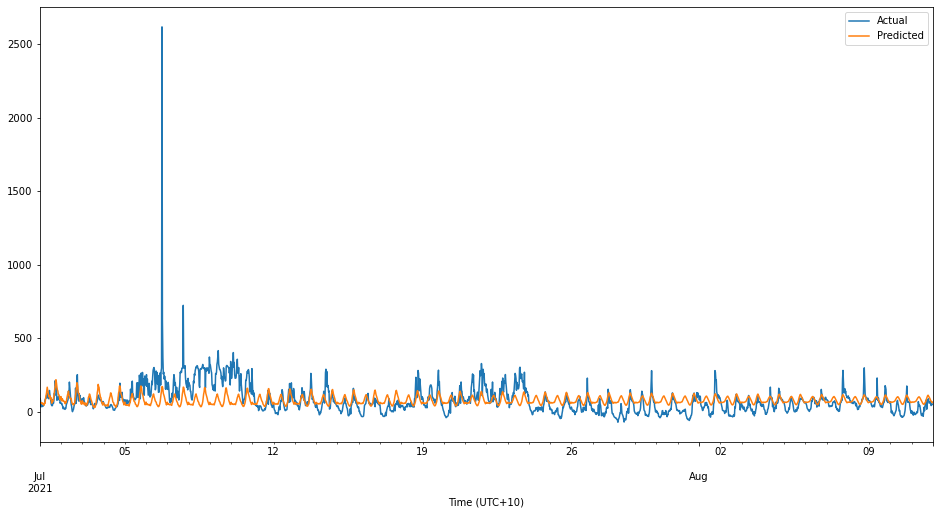

In [1328]:
expected = pd.DataFrame(tests, index=tests.index, columns=tests.columns)
forecast = pd.DataFrame(predicted_price.to_numpy(), index=tests.index)
dataframe = pd.concat([ expected["Regions VIC Trading Price ($/MWh)"],forecast[0]], axis=1)
dataframe.index = pd.to_datetime(dataframe.index)
dataframe.columns = ['Actual', 'Predicted']
#dataframe
dataframe.plot(figsize = (16, 8))

### To-be added
-  <strike>different metrics</strike>
- <strike>log trf</strike>
- <strike>log-diff</strike>
- <strike>double check prediction on manual calculation</strike>